In [1]:
import os
import sys
import json
import numpy as np
import time
import cv2
from PIL import Image, ImageDraw
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage

In [5]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = '/home/florent/_Ecole/INSA/PSAT/Detection Nageur PFE/Detecteur_nageur/'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

2021-10-21 13:48:17.956356: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/cv2/../../lib64:
2021-10-21 13:48:17.956443: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")


# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [7]:
class NageursConfig(Config):
    """Configuration pour un entrainement fait sur un nageur.
    Model ispiré de l'original mais adapté à mon GPU
    """
    # Give the configuration a recognizable name
    NAME = "nageur"

    # Batch size = GPU*Img (mieux si élevé mais dépend de la mémoire disponible)
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Nombres de Classes
    NUM_CLASSES = 1 + 1  # background + 1 (nageur)
    #ATTENTION : Le background est généré automatiquement, si dans le fichier JSON des annotations il existe une classe background,
    #pensez à la supprimer. Sinon vous aurez une erreur.

    # Shap
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    #Depend de la mémoire, si peu de mémoire, bcps de step.
    STEPS_PER_EPOCH = 1000

    VALIDATION_STEPS = 5
    
    # choix du backbone, peut être modifié si on ajoute un autre backbone dans le fichier model.py
    BACKBONE = 'resnet50'
    #paramètre du RPN
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = NageursConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [8]:
/home/florent/_Ecole/INSA/PSAT/Detection Nageur PFE/Detecteur_nageur/datasets/nageur/val//home/florent/_Ecole/INSA/PSAT/Detection Nageur PFE/Detecteur_nageur/datasets/nageur/val/#Fonction qui transforme le fichier JSON dans le format du dataset nécéssaire pour l'entrainement et la validation.
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            #if class_id < 1:
            #    print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
            #    return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            print (image_id)
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    print (image_file_name)
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [10]:
#En entrée : path vers le fichier d'annotation, path vers le dossier contenant les images.
'''dataset_train = CocoLikeDataset()
dataset_train.load_data('C:/Users/alexi/Detecteur_nageur/datasets/nageur/train/coco_annotations.json', 'C:/Users/alexi/Detecteur_nageur/datasets/nageur/train/images')
dataset_train.prepare()
'''
dataset_train = CocoLikeDataset()
dataset_train.load_data(ROOT_DIR + '/datasets/nageur/val/coco_annotations.json', ROOT_DIR + '/datasets/nageur/val/images')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data(ROOT_DIR + '/datasets/nageur/val/coco_annotations.json', ROOT_DIR + '/datasets/nageur/val/images')
dataset_val.prepare()

0
Brasse H Montpellier (1).jpg
1
Brasse H Montpellier (10).jpg
2
Brasse H Montpellier (11).jpg
3
Brasse H Montpellier (12).jpg
4
Brasse H Montpellier (13).jpg
5
Brasse H Montpellier (14).jpg
6
Brasse H Montpellier (15).jpg
7
Brasse H Montpellier (16).jpg
8
Brasse H Montpellier (17).jpg
9
Brasse H Montpellier (18).jpg
10
Brasse H Montpellier (19).jpg
11
Brasse H Montpellier (2).jpg
12
Brasse H Montpellier (20).jpg
13
Brasse H Montpellier (21).jpg
14
Brasse H Montpellier (22).jpg
15
Brasse H Montpellier (23).jpg
16
Brasse H Montpellier (24).jpg
17
Brasse H Montpellier (25).jpg
18
Brasse H Montpellier (26).jpg
19
Brasse H Montpellier (27).jpg
20
Brasse H Montpellier (28).jpg
21
Brasse H Montpellier (29).jpg
22
Brasse H Montpellier (3).jpg
23
Brasse H Montpellier (30).jpg
24
Brasse H Montpellier (4).jpg
25
Brasse H Montpellier (5).jpg
26
Brasse H Montpellier (6).jpg
27
Brasse H Montpellier (7).jpg
28
Brasse H Montpellier (8).jpg
29
Brasse H Montpellier (9).jpg
30
Dos Homme Collines (1).jpg

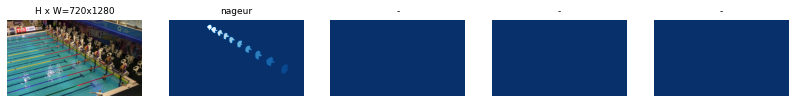

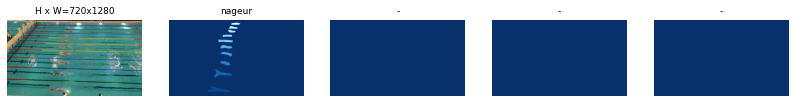

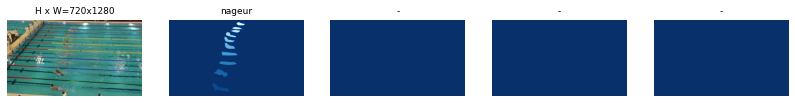

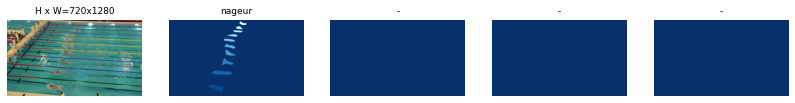

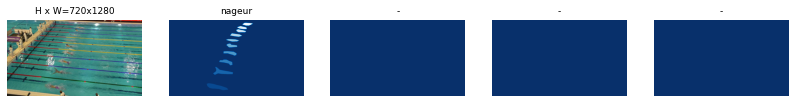

In [11]:
dataset = dataset_train
for i in range (5):
    image = dataset.load_image(i)
    mask, class_ids = dataset.load_mask(i)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2021-10-21 13:53:53.272295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/cv2/../../lib64:
2021-10-21 13:53:53.272320: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-21 13:53:53.272342: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (E550): /proc/driver/nvidia/version does not exist


In [13]:
#Choix du début de l'entrainement pour le fine tuning
init_with = "coco"  #  coco or last

if init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

2021-10-21 13:54:19.665926: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-21 13:54:20.454341: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2394530000 Hz
2021-10-21 13:54:22.149471: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
2021-10-21 13:54:22.698253: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.


In [14]:
# Train head Layers
# Les autres branches sont figées pendant l'entrainement

start_train = time.time()
model.train(dataset_train,
            dataset_val,            
            learning_rate=0.0001, 
            epochs=15, 
            layers='heads',
            augmentation = iaa.Sometimes(2/3,iaa.OneOf([iaa.Flipud(1)])))#augmentation miroire
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/florent/_Ecole/INSA/PSAT/Detection Nageur PFE/Detecteur_nageur/logs/nageur20211021T1354/mask_rcnn_nageur_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc 

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-10-21 13:54:56.439989: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 51380224 exceeds 10% of free system memory.
/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to a

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

Epoch 1/15


/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please 

   1/1000 [..............................] - ETA: 6:16:02 - batch: 0.0000e+00 - size: 1.0000 - loss: 2.3111 - rpn_class_loss: 0.2938 - rpn_bbox_loss: 1.5188 - mrcnn_class_loss: 0.4985 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
2021-10-21 13:55:38.598089: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-10-21 13:55:38.598146: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-10-21 13:55:45.815137: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-21 13:55:45.878415: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-10-21 13:55:45.982009: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /home/florent/_Ecole/INSA/PSAT/Detec

   2/1000 [..............................] - ETA: 2:05:01 - batch: 0.5000 - size: 1.0000 - loss: 2.2579 - rpn_class_loss: 0.2930 - rpn_bbox_loss: 1.5102 - mrcnn_class_loss: 0.4547 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00    

2021-10-21 13:55:46.063400: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /home/florent/_Ecole/INSA/PSAT/Detection Nageur PFE/Detecteur_nageur/logs/nageur20211021T1354/plugins/profile/2021_10_21_13_55_45
2021-10-21 13:55:46.063681: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to /home/florent/_Ecole/INSA/PSAT/Detection Nageur PFE/Detecteur_nageur/logs/nageur20211021T1354/plugins/profile/2021_10_21_13_55_45/E550.memory_profile.json.gz
2021-10-21 13:55:46.065885: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: /home/florent/_Ecole/INSA/PSAT/Detection Nageur PFE/Detecteur_nageur/logs/nageur20211021T1354/plugins/profile/2021_10_21_13_55_45Dumped tool data for xplane.pb to /home/florent/_Ecole/INSA/PSAT/Detection Nageur PFE/Detecteur_nageur/logs/nageur20211021T1354/plugins/profile/2021_10_21_13_55_45/E550.xplane.pb
Dumped tool data for overview_page.pb to /hom

   3/1000 [..............................] - ETA: 1:59:01 - batch: 1.0000 - size: 1.0000 - loss: 2.1856 - rpn_class_loss: 0.2917 - rpn_bbox_loss: 1.4969 - mrcnn_class_loss: 0.3971 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   4/1000 [..............................] - ETA: 2:01:47 - batch: 1.5000 - size: 1.0000 - loss: 2.1084 - rpn_class_loss: 0.2899 - rpn_bbox_loss: 1.4798 - mrcnn_class_loss: 0.3388 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   5/1000 [..............................] - ETA: 2:01:56 - batch: 2.0000 - size: 1.0000 - loss: 2.5670 - rpn_class_loss: 0.2730 - rpn_bbox_loss: 1.4996 - mrcnn_class_loss: 0.4070 - mrcnn_bbox_loss: 0.2384 - mrcnn_mask_loss: 0.1490        

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   6/1000 [..............................] - ETA: 2:01:27 - batch: 2.5000 - size: 1.0000 - loss: 2.8641 - rpn_class_loss: 0.2612 - rpn_bbox_loss: 1.5121 - mrcnn_class_loss: 0.4244 - mrcnn_bbox_loss: 0.4196 - mrcnn_mask_loss: 0.2468

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   7/1000 [..............................] - ETA: 2:02:42 - batch: 3.0000 - size: 1.0000 - loss: 3.0870 - rpn_class_loss: 0.2523 - rpn_bbox_loss: 1.5198 - mrcnn_class_loss: 0.4624 - mrcnn_bbox_loss: 0.5364 - mrcnn_mask_loss: 0.3160

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   8/1000 [..............................] - ETA: 2:01:58 - batch: 3.5000 - size: 1.0000 - loss: 3.2492 - rpn_class_loss: 0.2452 - rpn_bbox_loss: 1.5243 - mrcnn_class_loss: 0.4959 - mrcnn_bbox_loss: 0.6155 - mrcnn_mask_loss: 0.3684

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   9/1000 [..............................] - ETA: 2:00:18 - batch: 4.0000 - size: 1.0000 - loss: 3.0473 - rpn_class_loss: 0.2250 - rpn_bbox_loss: 1.5059 - mrcnn_class_loss: 0.4418 - mrcnn_bbox_loss: 0.5471 - mrcnn_mask_loss: 0.3274

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  10/1000 [..............................] - ETA: 1:58:53 - batch: 4.5000 - size: 1.0000 - loss: 2.8834 - rpn_class_loss: 0.2087 - rpn_bbox_loss: 1.4894 - mrcnn_class_loss: 0.3982 - mrcnn_bbox_loss: 0.4924 - mrcnn_mask_loss: 0.2947

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  11/1000 [..............................] - ETA: 1:57:14 - batch: 5.0000 - size: 1.0000 - loss: 2.7457 - rpn_class_loss: 0.1952 - rpn_bbox_loss: 1.4726 - mrcnn_class_loss: 0.3623 - mrcnn_bbox_loss: 0.4477 - mrcnn_mask_loss: 0.2679

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  12/1000 [..............................] - ETA: 1:56:06 - batch: 5.5000 - size: 1.0000 - loss: 2.6269 - rpn_class_loss: 0.1838 - rpn_bbox_loss: 1.4549 - mrcnn_class_loss: 0.3324 - mrcnn_bbox_loss: 0.4103 - mrcnn_mask_loss: 0.2456

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  13/1000 [..............................] - ETA: 1:55:24 - batch: 6.0000 - size: 1.0000 - loss: 2.6293 - rpn_class_loss: 0.1784 - rpn_bbox_loss: 1.4188 - mrcnn_class_loss: 0.3204 - mrcnn_bbox_loss: 0.4228 - mrcnn_mask_loss: 0.2890

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  14/1000 [..............................] - ETA: 1:54:23 - batch: 6.5000 - size: 1.0000 - loss: 2.6259 - rpn_class_loss: 0.1737 - rpn_bbox_loss: 1.3873 - mrcnn_class_loss: 0.3098 - mrcnn_bbox_loss: 0.4295 - mrcnn_mask_loss: 0.3257

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  15/1000 [..............................] - ETA: 1:53:34 - batch: 7.0000 - size: 1.0000 - loss: 2.6131 - rpn_class_loss: 0.1696 - rpn_bbox_loss: 1.3592 - mrcnn_class_loss: 0.2977 - mrcnn_bbox_loss: 0.4305 - mrcnn_mask_loss: 0.3561

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  16/1000 [..............................] - ETA: 1:53:04 - batch: 7.5000 - size: 1.0000 - loss: 2.6015 - rpn_class_loss: 0.1661 - rpn_bbox_loss: 1.3336 - mrcnn_class_loss: 0.2934 - mrcnn_bbox_loss: 0.4271 - mrcnn_mask_loss: 0.3814

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  17/1000 [..............................] - ETA: 1:52:25 - batch: 8.0000 - size: 1.0000 - loss: 2.6600 - rpn_class_loss: 0.1610 - rpn_bbox_loss: 1.3107 - mrcnn_class_loss: 0.3183 - mrcnn_bbox_loss: 0.4701 - mrcnn_mask_loss: 0.3998

/home/florent/anaconda3/envs/psat/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  86/1000 [=>............................] - ETA: 1:43:35 - batch: 42.5000 - size: 1.0000 - loss: 2.6239 - rpn_class_loss: 0.0851 - rpn_bbox_loss: 0.9979 - mrcnn_class_loss: 0.2928 - mrcnn_bbox_loss: 0.6718 - mrcnn_mask_loss: 0.5763

Process Keras_worker_ForkPoolWorker-1:
Process Keras_worker_ForkPoolWorker-4:
Process Keras_worker_ForkPoolWorker-3:
Process Keras_worker_ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/florent/anaconda3/envs/psat/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/florent/anaconda3/envs/psat/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/florent/anaconda3/envs/psat/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/florent/anaconda3/envs/psat/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/florent/anaconda3/envs/psat/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/florent/anaconda3/envs

KeyboardInterrupt: 

Process Keras_worker_ForkPoolWorker-5:
Traceback (most recent call last):
  File "/home/florent/anaconda3/envs/psat/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/florent/anaconda3/envs/psat/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/florent/anaconda3/envs/psat/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/florent/anaconda3/envs/psat/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/home/florent/anaconda3/envs/psat/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


In [ ]:
# Fine tuning sur tout le réseau (avec un learning rate plus faible, on est la pour affiner seulement)

start_train = time.time()
model.train(dataset_train,
            dataset_val, 
            learning_rate=0.0001,
            epochs=30, 
            layers="all",
            augmentation = iaa.Sometimes(1/2,iaa.OneOf([iaa.Flipud(1)])))#augmentation miroire
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')